# Simulation Experiments

We simulate a greybox fuzing campaign to understand the behavior of discovery probability as more inputs are generated. In contrast to a blackbox fuzzer, a greybox fuzzer adds inputs to the corpus that discover a new species (e.g., that cover a new program branch).

We simulate  𝑇𝑟𝑖𝑎𝑙=30  many greybox campaigns of length  𝐿𝑒𝑛𝑔𝑡ℎ=50000  generated test inputs, where the subject has  𝑆=50  species. We take data points in exponentially increasing intervals ( 𝑁𝑅𝑎𝑛𝑔𝑒 ).

Seeds are identified by their species (species are identified by a number between 0 and  𝑆 ). In order to derive the local species distribution for a seed, we assume that there exists some template distribution  𝑊𝑒𝑖𝑔ℎ𝑡𝑠 . This captures that, irrespective of the current seed, some species are always abundant, while some are always rare. The  𝐺𝑟𝑎𝑣𝑖𝑡𝑦  parameter determines how close the local distribution of a seed is to that template distribution.

𝑊𝑒𝑖𝑔ℎ𝑡𝑠  is defined such that there are very few highly abundandt species and a lot of very rare species. Specifically, species  𝑖  is  𝐿𝑎𝑚𝑏𝑑𝑎=1.3  times more likely than species  𝑖+1 .

The initial corpus is  𝐶𝑜𝑟𝑝𝑢𝑠=5  and a very rare species is marked as "buggy" ( 𝐵𝑢𝑔=40 ).

## Initialize

This Jupyter notebook allows you to simulate black- and greybox fuzzing campaigns to generate results presented in https://github.com/Adaptive-Bias/fse21_paper270.
We executed this notebook with the following versions.
```
✔ ggplot2 3.1.1     ✔ scales_1.0.0
✔ dplyr   1.0.6
```
To install a missing package use, e.g.,
```
install.packages("ggplot2",dependencies=TRUE)
```
To install a specific version of a package use, e.g.,
```
require(devtools)
install_version("ggplot2", version = "3.1.1", repos = "http://cran.us.r-project.org")
```

Required packages

In [1]:
library(ggplot2)  
library(scales)  
library(grid)  
library(dplyr)

theme_set(theme_bw())
options(warn=-1)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Simulation Configuration

In [2]:
# Configuration
S       = 50     # number of species
Length  = 50000  # number of test cases
Trials  = 30     # number of experiment repetitions
NRange  = c(1.2^seq(0,log2(Length)/log2(1.2)), Length) # data points

Lambda  = 1.3    # probability decrease factor
Gravity = 100    # Impact of Weight on local distribution

Corpus  = c(5)   # We start with one initial seed that is neither too likely nor too unlikely if sampled from 1:S according to Weights.
Bug     = 40     # id of buggy species (higher id means more difficult to find)

# Weights will be used to derive local distributions
# As Gravity approaches infty, a local distribution approaches Weights.
Weights = rep(0,S)
for (i in 1:S) {
  if (i == 1)
    Weights[i] = 0.5
  else Weights[i] = Weights[i - 1] / Lambda
}
Weights = Weights / sum(Weights)

# Just some stats
print("10 smallest probabilities:")
print(tail(Weights, n=10))

print(paste("10 samples between 1 and ", S, ":", sep=""))
print(sample(1:S, replace=TRUE, 10, prob=Weights))

[1] "10 smallest probabilities:"
 [1] 6.389174e-06 4.914749e-06 3.780576e-06 2.908135e-06 2.237027e-06
 [6] 1.720790e-06 1.323685e-06 1.018219e-06 7.832454e-07 6.024965e-07
[1] "10 samples between 1 and 50:"
 [1] 3 4 1 3 6 4 2 4 2 1


## How we derive the local distribution for a seed.

In [3]:
local_distribution = function(seed) {
  local_weights = rep(0,S)
  local_weights[seed] = 0.5

  # Decrease probability on the left and right of seed.
  left = seed - 1
  while (left >= 1) {
    local_weights[left] = local_weights[left + 1] / Lambda
    left = left - 1
  }
  right = seed + 1
  while (right <= S) {
    local_weights[right] = local_weights[right - 1] / Lambda
    right = right + 1
  }
  
  # Add to Weights. The key idea is that some species (statements/branches)
  # are always very likely or very unlikely, irrespective of the seed.
  local_weights = local_weights / Gravity + Weights

  # Normalize
  return(local_weights / sum(local_weights))
}

## Power Schedule

We start with a power schedule that chooses all seeds uniformely.

In [4]:
power_schedule = function(corpus) {
  # Uniform distribution
  return (rep(1/length(corpus), length(corpus)))

  # Prefer later seeds
  #weights = seq(1:length(corpus))
  #return (weights / sum(weights))
}
print(power_schedule(Corpus))
print(power_schedule(c(1,2)))

[1] 1
[1] 0.5 0.5


Let's Simulate

In [5]:
data = data.frame("Run"=character(),"Fuzzer"=character(), "n"=integer(), "factor"=character(), "value"=numeric())
for (N in NRange) {
  # Assuming there is only one initial seed
  pi = local_distribution(Corpus[1])
  data = rbind(data,
               data.frame(Run=1, # We only need one run as there is no sampling
                                 Fuzzer="Blackbox", n=N, factor="Discovery probability", value=sum(pi * (1-pi)^N)),
               data.frame(Run=1, Fuzzer="Blackbox", n=N, factor="#Species discovered", value=sum(1-(1-pi)^N)),
               data.frame(Run=1, Fuzzer="Blackbox", n=N, factor="Residual risk", value=pi[Bug]))
}

time_to_error = c()
for (run in 1:Trials) {
  timestamps = list()
    
  # Construct corpus
  current_C = Corpus
  for (N in 1:Length) {
    seed = sample(1:length(current_C), 1, prob=power_schedule(current_C))
    species = sample(1:S, 1, prob=local_distribution(seed))
    #print(current_C)
    if (! species %in% current_C) {
      current_C = c(current_C, species)
      timestamps[[toString(N)]] = current_C
    }
  }

  # Derive discovery probability  values at time stamps
  for (N in NRange) {
    # Find current corpus at time N
    current_C = Corpus
    for (n in names(timestamps)) {
      if (as.integer(n) >= N)
        break
      else 
        current_C = timestamps[[n]]
    }
    if (Bug %in% current_C) {
      time_to_error = c(time_to_error, as.integer(n))
    }

    # Derive global distribution pi from local distributions and power schedule
    pi = rep(0,S)
    qt = power_schedule(current_C)
    for (t in 1:length(current_C)) {
      pi = pi + qt[t] * local_distribution(current_C[t])
    }
    
    # Compute discovery probability
    discovery_probability = sum(unlist(lapply(sample(1:S, N*2, replace=TRUE, prob=pi), function(x) ifelse(x %in% current_C,0,1)))) / (N * 2)
    
    # Append to data frame
    data = rbind(data,
                 data.frame(Run=run, Fuzzer="Greybox", n=N, factor="Discovery probability",value=discovery_probability),
                 data.frame(Run=run, Fuzzer="Greybox", n=N, factor="#Species discovered", value=length(current_C)),
                 data.frame(Run=run, Fuzzer="Greybox", n=N, factor="Bug Probability", value=pi[Bug]))
  }
}

In [6]:
print(paste("[Blackbox] Avg. time to error: ", 1/local_distribution(Corpus[1])[Bug]))
if (length(time_to_error) == 0) {
  print("[Greybox] Error not found.")
} else {
  print(paste("[Greybox] Avg. time to error: ", mean(time_to_error)))
}
summary(subset(data,factor=="Discovery probability"))

[1] "[Blackbox] Avg. time to error:  117064.38854363"
[1] "[Greybox] Avg. time to error:  11413.1925925926"


      Run             Fuzzer           n           
 Min.   : 1.00   Blackbox:  61   Min.   :    1.00  
 1st Qu.: 7.00   Greybox :1830   1st Qu.:   15.41  
 Median :15.00                   Median :  237.38  
 Mean   :15.03                   Mean   : 5438.24  
 3rd Qu.:23.00                   3rd Qu.: 3657.26  
 Max.   :30.00                   Max.   :50000.00  
                   factor         value         
 Discovery probability:1891   Min.   :0.000000  
 #Species discovered  :   0   1st Qu.:0.002465  
 Residual risk        :   0   Median :0.017471  
 Bug Probability      :   0   Mean   :0.148031  
                              3rd Qu.:0.195630  
                              Max.   :1.000000  

Compute the average residual risk and number of discovered species over all runs.

In [7]:
mean_data = data %>%
  group_by(Fuzzer, factor, n) %>%
  summarize(value = mean(value, na.rm = TRUE))

summary(mean_data)

`summarise()` has grouped output by 'Fuzzer', 'factor'. You can override using the `.groups` argument.


      Fuzzer                      factor          n           
 Blackbox:183   Discovery probability:122   Min.   :    1.00  
 Greybox :183   #Species discovered  :122   1st Qu.:   15.41  
                Residual risk        : 61   Median :  237.38  
                Bug Probability      : 61   Mean   : 5438.24  
                                            3rd Qu.: 3657.26  
                                            Max.   :50000.00  
     value         
 Min.   : 0.00000  
 1st Qu.: 0.00002  
 Median : 0.01910  
 Mean   : 6.89961  
 3rd Qu.: 7.58726  
 Max.   :50.00000  

## Results

Saving 2.8 x 2.8 in image


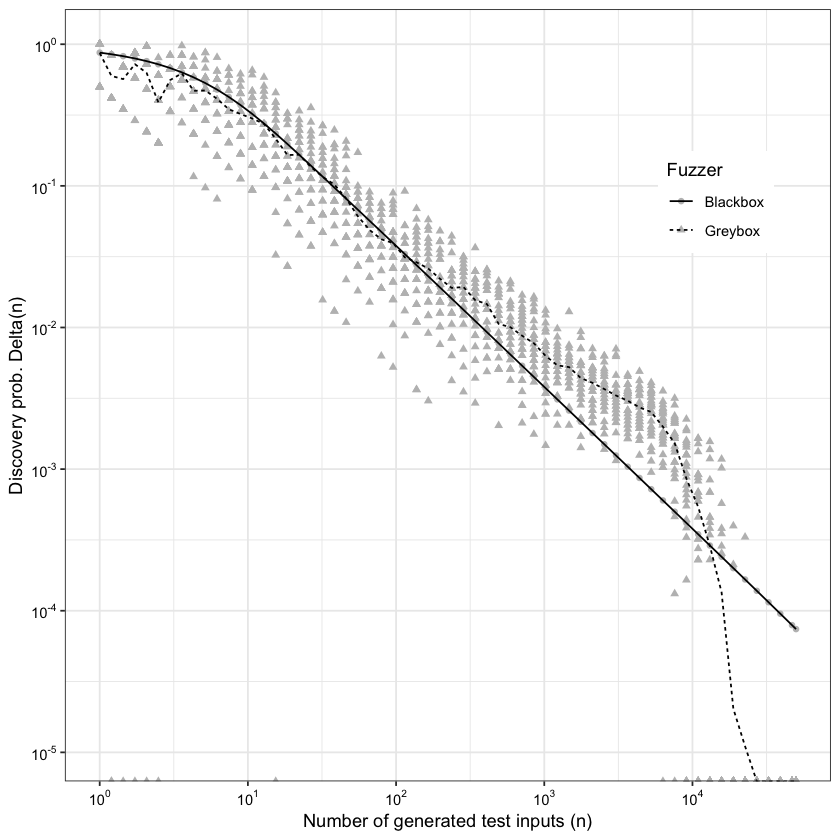

Saving 2.8 x 2.8 in image


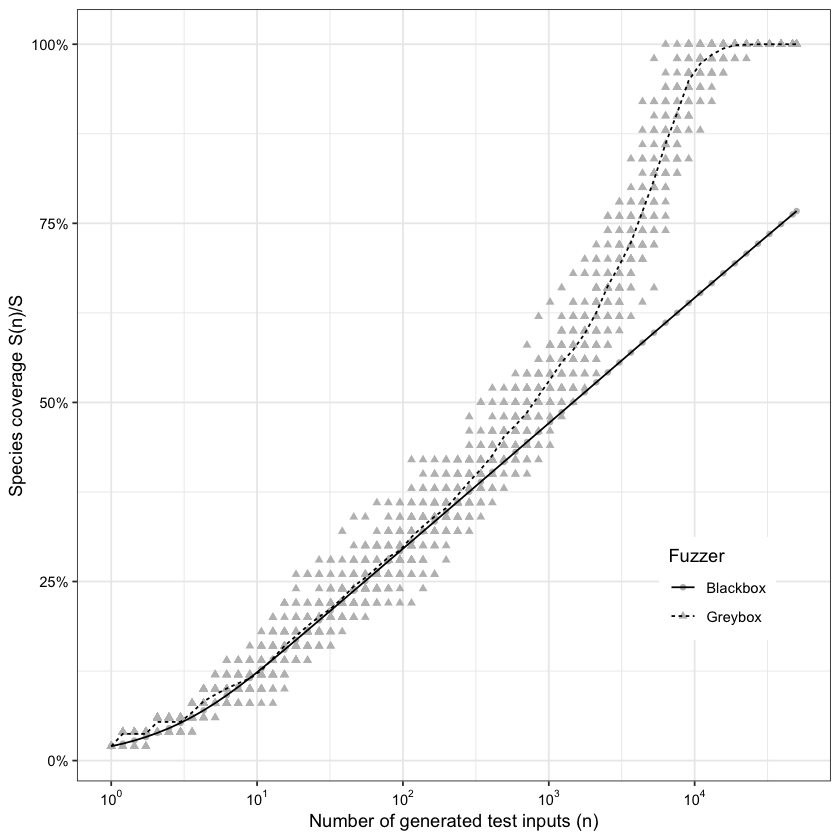

In [8]:
ggplot(subset(data, factor=="Discovery probability"), aes(n, value)) +
  geom_point(aes(shape=Fuzzer),color="gray") +
  geom_line(data=subset(mean_data, factor=="Discovery probability"), aes(n, value, linetype=Fuzzer)) +
  #geom_smooth(aes(linetype=Fuzzer), color ="black") +
  scale_x_log10("Number of generated test inputs (n)",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  scale_y_log10("Discovery prob. Delta(n)",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  #facet_wrap(~ factor, ncol=1, scale="free") +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"), legend.position = c(0.85, 0.75))
ggsave("../outputs/residual.pdf",scale=0.4)

ggplot(subset(data, factor=="#Species discovered"), aes(n, value / S)) +
  geom_point(aes(shape=Fuzzer), color="gray") +
  #geom_smooth(aes(linetype=Fuzzer), color ="black") +
  geom_line(data=subset(mean_data, factor=="#Species discovered"), aes(n, value / S, linetype=Fuzzer)) +
  scale_x_log10("Number of generated test inputs (n)",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  scale_y_continuous("Species coverage S(n)/S",
                     labels=percent) +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"), legend.position = c(0.85, 0.25))
ggsave("../outputs/species.pdf",scale=0.4)

## Goodness-Of-Fit of an Extrapolation by Orders of Magnitude

In [9]:
summary(lm(formula = log(subset(data, Fuzzer=="Blackbox" & factor=="Discovery probability" & value>0)$n) ~ log(subset(data, Fuzzer=="Blackbox" & factor=="Discovery probability" & value>0)$value)))
summary(lm(formula = log(subset(data, Fuzzer=="Greybox" & factor=="Discovery probability" & value>0)$n) ~ log(subset(data, Fuzzer=="Greybox" & factor=="Discovery probability" & value>0)$value)))


Call:
lm(formula = log(subset(data, Fuzzer == "Blackbox" & factor == 
    "Discovery probability" & value > 0)$n) ~ log(subset(data, 
    Fuzzer == "Blackbox" & factor == "Discovery probability" & 
        value > 0)$value))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.03524 -0.10537  0.05958  0.20143  0.29576 

Coefficients:
                                                                                              Estimate
(Intercept)                                                                                    0.88991
log(subset(data, Fuzzer == "Blackbox" & factor == "Discovery probability" & value > 0)$value) -1.06703
                                                                                              Std. Error
(Intercept)                                                                                      0.06337
log(subset(data, Fuzzer == "Blackbox" & factor == "Discovery probability" & value > 0)$value)    0.01211
                               


Call:
lm(formula = log(subset(data, Fuzzer == "Greybox" & factor == 
    "Discovery probability" & value > 0)$n) ~ log(subset(data, 
    Fuzzer == "Greybox" & factor == "Discovery probability" & 
        value > 0)$value))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.67050 -0.42000  0.07257  0.48806  1.52089 

Coefficients:
                                                                                              Estimate
(Intercept)                                                                                   0.477435
log(subset(data, Fuzzer == "Greybox" & factor == "Discovery probability" & value > 0)$value) -1.245480
                                                                                             Std. Error
(Intercept)                                                                                    0.032244
log(subset(data, Fuzzer == "Greybox" & factor == "Discovery probability" & value > 0)$value)   0.008063
                                    

pdf 
  2

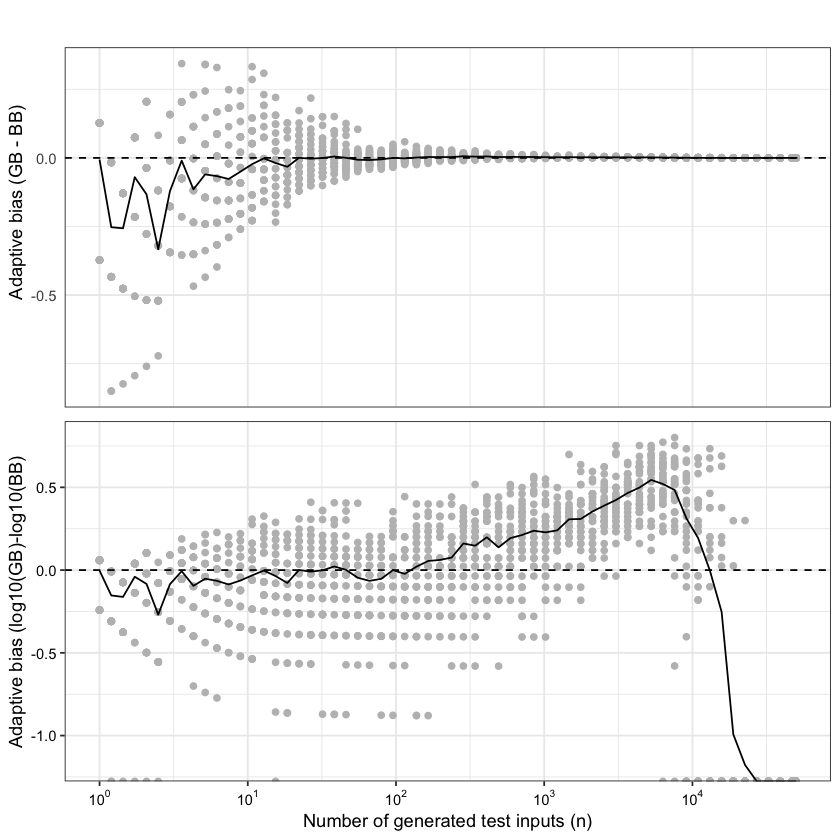

In [10]:
logbias = log10(subset(data, Fuzzer == "Greybox" & factor=="Discovery probability" )$value) - log10(subset(data, Fuzzer == "Blackbox"& factor=="Discovery probability")$value)
logbias_avg = log10(subset(mean_data, Fuzzer == "Greybox" & factor=="Discovery probability" )$value) - log10(subset(mean_data, Fuzzer == "Blackbox"& factor=="Discovery probability")$value)

p1 = ggplot() + 
  geom_point(aes(x=rep(NRange,Trials), y=logbias), color="gray") +
  geom_hline(yintercept=0, color="black", linetype="dashed") +
  geom_line(aes(x=NRange, y=logbias_avg), color="black") +
  #geom_smooth(aes(x=rep(NRange,1), y=bias), color="black") +
  scale_x_log10("Number of generated test inputs (n)",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  scale_y_continuous("Adaptive bias (log10(GB)-log10(BB)") +
  #facet_wrap(~c("Log-Difference (log(GB)-log(BB)"),strip.position="right") +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"))
#ggsave("bias.pdf",scale=0.4)

bias = (subset(data, Fuzzer == "Greybox" & factor=="Discovery probability" )$value) - (subset(data, Fuzzer == "Blackbox"& factor=="Discovery probability")$value)
bias_avg = (subset(mean_data, Fuzzer == "Greybox" & factor=="Discovery probability" )$value) - (subset(mean_data, Fuzzer == "Blackbox"& factor=="Discovery probability")$value)
p2 = ggplot() + 
  geom_point(aes(x=rep(NRange,Trials), y=bias), color="gray") +
  geom_hline(yintercept=0, color="black", linetype="dashed") +
  geom_line(aes(x=NRange, y=bias_avg), color="black") +
  #geom_smooth(aes(x=rep(NRange,1), y=bias), color="black") +
  scale_x_log10("Number of generated test inputs (n)",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  scale_y_continuous("          Adaptive bias (GB - BB)") +
  #facet_wrap(~c("Difference (GB - BB)"),strip.position="right") +
  theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks=element_blank(),
        plot.margin = unit(c(1,1,0,1), "cm"))
                
grid.newpage()
grid.draw(rbind(ggplotGrob(p2), ggplotGrob(p1), size = "last"))

pdf("../outputs/bias.pdf", width=5, height=5)
grid.newpage()
grid.draw(rbind(ggplotGrob(p2), ggplotGrob(p1), size = "last"))
dev.off()

Saving 2.8 x 3.2 in image


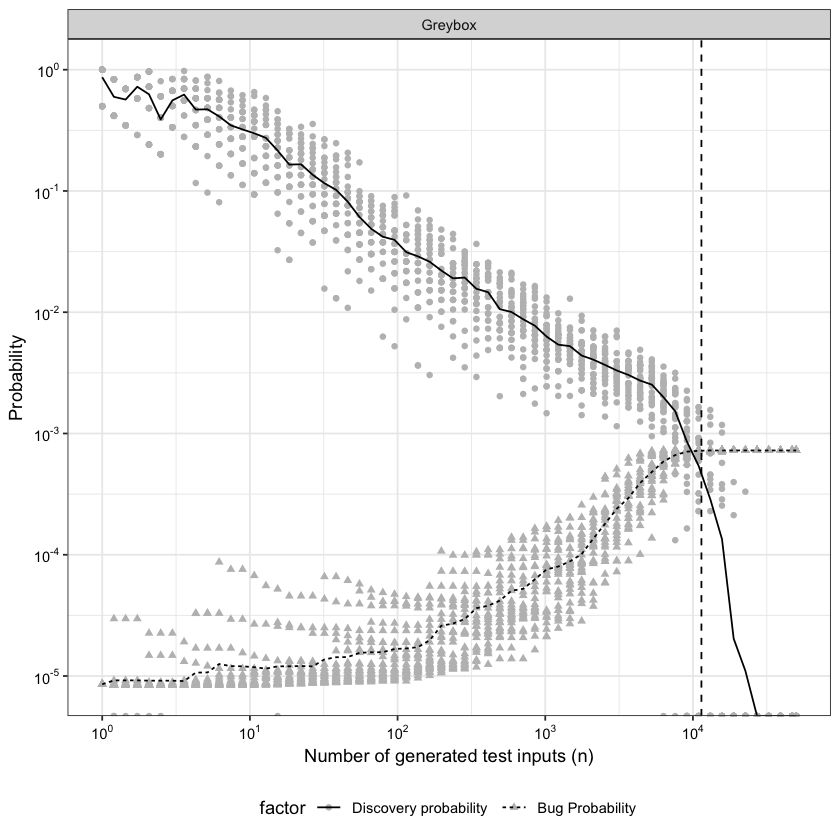

In [11]:
ggplot(subset(data, Fuzzer == "Greybox" & factor %in% c("Bug Probability","Discovery probability")), aes(n, value)) +
  geom_point(aes(shape=factor),color="gray") +
  #geom_smooth(aes(linetype=factor), color ="black") +
  geom_line(data=subset(mean_data, Fuzzer == "Greybox" & factor %in% c("Bug Probability","Discovery probability")), aes(linetype=factor),color="black") +
  geom_vline(aes(xintercept=mean(time_to_error)),linetype="dashed") + 
  scale_x_log10("Number of generated test inputs (n)",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  scale_y_log10("Probability",
                breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
  facet_wrap(~Fuzzer) +
  theme(axis.text.x = element_text(colour="black"), axis.text.y = element_text(colour="black"), legend.position = "bottom")
ggsave("../outputs/risk.pdf",scale=0.4, height=8)